# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109A Introduction to Data Science: 
## Homework 4 - Regularization 


**Submitted by**: Erin Williams

**Harvard University**<br/>
**Fall 2018**<br/>
**Instructors**: Pavlos Protopapas, Kevin Rader

<hr style="height:2pt">

### INSTRUCTIONS

- **This homework must be completed individually.**

- To submit your assignment follow the instructions given in Canvas.
- Restart the kernel and run the whole notebook again before you submit. 
- As much as possible, try and stick to the hints and functions we import at the top of the homework, as those are the ideas and tools the class supports and is aiming to teach. And if a problem specifies a particular library you're required to use that library, and possibly others from the import list.


Names of people you have worked with goes here: 

<hr style="height:2pt">

In [1]:
#RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

import these libraries

In [2]:
import warnings
#warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import KFold

import statsmodels.api as sm
from statsmodels.regression.linear_model import OLS

from pandas.core import datetools
%matplotlib inline

C:\Users\erina\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.


# Continuing Bike Sharing Usage Data

In this homework, we will focus on regularization and cross validation. We will continue to build regression models for the [Capital Bikeshare program](https://www.capitalbikeshare.com) in Washington D.C.  See homework 3 for more information about the Capital Bikeshare data that we'll be using extensively. 



<div class='exercise'> <b> Question 1 [20pts]  Data pre-processing </b> </div>

**1.1** Read in the provided `bikes_student.csv` to a data frame named `bikes_main`. Split it into a training set `bikes_train` and a validation set `bikes_val`. Use `random_state=90`, a test set size of .2, and stratify on month. Remember to specify the data's index column as you read it in.

**1.2** As with last homework, the response will be the `counts` column and we'll drop `counts`, `registered` and `casual` for being trivial predictors, drop `workingday` and `month` for being multicollinear with other columns, and `dteday` for being inappropriate for regression. Write code to do this.

Encapsulate this process as a function with appropriate inputs and outputs, and **test** your code by producing `practice_y_train` and `practice_X_train`.

**1.3** Write a function to standardize a provided subset of columns in your training/validation/test sets. Remember that while you will be scaling all of your data, you must learn the scaling parameters (mean and SD) from only the training set.

Test your code by building a list of all non-binary columns in your `practice_X_train` and scaling only those columns. Call the result `practice_X_train_scaled`. Display the `.describe()` and verify that you have correctly scaled all columns, including the polynomial columns.

**Hint: employ the provided list of binary columns and use `pd.columns.difference()`**

`binary_columns = [ 'holiday', 'workingday','Feb', 'Mar', 'Apr',
       'May', 'Jun', 'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec', 'spring',
       'summer', 'fall', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat',
       'Cloudy', 'Snow', 'Storm']`


**1.4** Write a code to augment your a dataset with higher-order features for `temp`, `atemp`, `hum`,`windspeed`, and `hour`. You should include ONLY the pure powers of these columns. So with degree=2 you should produce `atemp^2` and `hum^2` but not `atemp*hum` or any other two-feature interactions. 


Encapsulate this process as a function with appropriate inputs and outputs, and test your code by producing `practice_X_train_poly`, a training dataset with quadratic and cubic features built from `practice_X_train_scaled`, and printing `practice_X_train_poly`'s column names and `.head()`.

**1.5** Write code to add interaction terms to the model. Specifically, we want interactions between the continuous predictors (`temp`,`atemp`, `hum`,`windspeed`) and the month and weekday dummies (`Feb`, `Mar`...`Dec`, `Mon`, `Tue`, ... `Sat`). That means you SHOULD build `atemp*Feb` and `hum*Mon` and so on, but NOT `Feb*Mar` and NOT `Feb*Tue`. The interaction terms should always be a continuous feature times a month dummy or a continuous feature times a weekday dummy.


Encapsulate this process as a function with appropriate inputs and outputs, and test your code by adding interaction terms to `practice_X_train_poly` and show its column names and `.head()`**

**1.6** Combine all your code so far into a function that takes in `bikes_train`, `bikes_val`, the names of columns for polynomial, the target column, the columns to be dropped and produces computation-ready design matrices `X_train` and `X_val` and responses `y_train` and `y_val`. Your final function should build correct, scaled design matrices with the stated interaction terms and any polynomial degree.



### Solutions 

**1.1** Read in the provided `bikes_student.csv` to a data frame named `bikes_main`. Split it into a training set `bikes_train` and a validation set `bikes_val`. Use `random_state=90`, a test set size of .2, and stratify on month. Remember to specify the data's index column as you read it in.

In [32]:
# your code here
bikes_main = pd.read_csv("data/bikes_student.csv", index_col = "Unnamed: 0")
display(bikes_main.head())

,dteday,hour,year,holiday,workingday,temp,atemp,hum,windspeed,casual,...,Mon,Tue,Wed,Thu,Fri,Sat,Cloudy,Snow,Storm,month
5887,2011-09-07,19,0,0,1,0.64,0.5758,0.89,0.0000,14,...,0,0,1,0,0,0,1,0,0,9
10558,2012-03-21,1,1,0,1,0.52,0.5000,0.83,0.0896,4,...,0,0,1,0,0,0,0,0,0,3
14130,2012-08-16,23,1,0,1,0.70,0.6515,0.54,0.1045,58,...,0,0,0,1,0,0,0,0,0,8
2727,2011-04-28,13,0,0,1,0.62,0.5758,0.83,0.2985,18,...,0,0,0,1,0,0,1,0,0,4
8716,2012-01-04,0,1,0,1,0.08,0.0606,0.42,0.3284,0,...,0,0,1,0,0,0,0,0,0,1


In [4]:
bikes_train, bikes_val = train_test_split(bikes_main, random_state =90, test_size = 0.2, 
                                             stratify=bikes_main['month'])

**1.2** As with last homework, the response will be the `counts` column and we'll drop `counts`, `registered` and `casual` for being trivial predictors, drop `workingday` and `month` for being multicolinear with other columns, and `dteday` for being inappropriate for regression. Write code to do this.

Encapsulate this process as a function with appropriate inputs and outputs, and test your code by producing `practice_y_train` and `practice_X_train`


In [5]:
# your code here

def prepare_bikes_data(df, target_col='counts', 
                    bad_columns=['counts', 'registered', 'casual', 'workingday', 'month', 'dteday']):
    x_data = df.drop(bad_columns, axis=1)
    y_data = df[target_col]
    return x_data, y_data

In [6]:
practice_X_train, practice_y_train = prepare_bikes_data(bikes_train)

In [7]:
practice_X_train.head()

,hour,year,holiday,temp,atemp,hum,windspeed,Feb,Mar,Apr,...,fall,Mon,Tue,Wed,Thu,Fri,Sat,Cloudy,Snow,Storm
15762,23,1,0,0.54,0.5152,0.73,0.1045,0,0,0,...,1,0,1,0,0,0,0,0,0,0
4213,11,0,0,0.76,0.6667,0.35,0.2239,0,0,0,...,0,0,0,1,0,0,0,0,0,0
14301,2,1,0,0.66,0.6212,0.69,0.0000,0,0,0,...,0,0,0,0,0,1,0,0,0,0
15900,5,1,0,0.30,0.3030,0.81,0.1343,0,0,0,...,1,0,0,1,0,0,0,1,0,0
14320,21,1,0,0.70,0.6515,0.61,0.1642,0,0,0,...,0,0,0,0,0,1,0,1,0,0


**1.3** Write a function to standardize a provided subset of columns in your training/validation/test sets. Remember that while you will be scaling all of your data, you must learn the scaling parameters (mean and SD) from only the training set.

Test your code by building a list of all non-binary columns in your `practice_X_train` and scaling only those columns. Call the result `practice_X_train_scaled`. Display the `.describe()` and verify that you have correctly scaled all columns, including the polynomial columns.

**Hint: employ the provided list of binary columns and use `pd.columns.difference()`**

`binary_columns = [ 'holiday', 'workingday','Feb', 'Mar', 'Apr',
       'May', 'Jun', 'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec', 'spring',
       'summer', 'fall', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat',
       'Cloudy', 'Snow', 'Storm']`


In [8]:
# your code here
binary_columns = [ 'holiday','Feb', 'Mar', 'Apr',
       'May', 'Jun', 'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec', 'spring',
       'summer', 'fall', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat',
       'Cloudy', 'Snow', 'Storm']


In [9]:
def standardize_col(df, binary_columns=None):
    standard_df = df[df.columns.difference(binary_columns)]
    scaled_df = (standard_df-standard_df.mean())/standard_df.std()
    for i in binary_columns:
        try:
            scaled_df = scaled_df.join(df[i])
        except:
            continue
    return scaled_df

In [10]:
practice_X_train_scaled = standardize_col(practice_X_train, binary_columns)
practice_X_train.describe()

,hour,year,holiday,temp,atemp,hum,windspeed,Feb,Mar,Apr,...,fall,Mon,Tue,Wed,Thu,Fri,Sat,Cloudy,Snow,Storm
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,...,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1000.00000,1000.000000,1000.000000,1000.0
mean,11.319000,0.509000,0.027000,0.492780,0.472546,0.639740,0.195421,0.078000,0.085000,0.082000,...,0.248000,0.143000,0.148000,0.162000,0.128000,0.12700,0.15000,0.280000,0.082000,0.0
std,6.879431,0.500169,0.162164,0.192935,0.171544,0.188386,0.125800,0.268306,0.279021,0.274502,...,0.432068,0.350248,0.355278,0.368635,0.334257,0.33314,0.35725,0.449224,0.274502,0.0
min,0.000000,0.000000,0.000000,0.040000,0.060600,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.0
25%,5.000000,0.000000,0.000000,0.340000,0.333300,0.500000,0.104500,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.0
50%,11.000000,1.000000,0.000000,0.500000,0.484800,0.650000,0.194000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.0
75%,17.000000,1.000000,0.000000,0.660000,0.621200,0.800000,0.253700,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,1.000000,0.000000,0.0
max,23.000000,1.000000,1.000000,0.940000,0.909100,1.000000,0.850700,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.00000,1.000000,1.000000,0.0


**1.4** Write a code to augment your a dataset with higher-order features for `temp`, `atemp`, `hum`,`windspeed`, and `hour`. You should include ONLY pure powers of these columns. So with degree=2 you should produce `atemp^2` and `hum^2` but not `atemp*hum` or any other two-feature interactions. 


Encapsulate this process as a function with apropriate inputs and outputs, and test your code by producing `practice_X_train_poly`, a training dataset with qudratic and cubic features built from `practice_X_train_scaled`, and printing `practice_X_train_poly`'s column names and `.head()`.

In [11]:
def build_poly_model(df, degree, col_list = None):
    df2 = df.copy()
    new_df = df[col_list]
    df_poly = df.copy()[[]]
    for n in np.arange(2,degree+1):
        for column in new_df:     
            df_poly[column] = df2[column].values**n
            df_poly.rename(columns = {column : column + '^' + str(n)}, inplace = True)
    final_df = df.join(df_poly)
    return final_df
    

In [12]:
# your code here
cols = [ 'temp','atemp', 'hum', 'windspeed',
       'hour']
practice_X_train_poly = build_poly_model(practice_X_train_scaled, 2, cols)
practice_X_train_poly.describe()

,atemp,hour,hum,temp,windspeed,year,holiday,Feb,Mar,Apr,...,Fri,Sat,Cloudy,Snow,Storm,temp^2,atemp^2,hum^2,windspeed^2,hour^2
count,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1000.000000,1000.000000,1000.000000,1000.000000,...,1000.00000,1000.00000,1000.000000,1000.000000,1000.0,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,4.076295e-15,-9.588164e-17,-4.017564e-15,-4.009237e-15,8.886558e-15,2.779998e-16,0.027000,0.078000,0.085000,0.082000,...,0.12700,0.15000,0.280000,0.082000,0.0,0.999000,0.999000,0.999000,0.999000,0.999000
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.162164,0.268306,0.279021,0.274502,...,0.33314,0.35725,0.449224,0.274502,0.0,1.009891,1.040689,1.114150,1.767682,0.896636
min,-2.401403e+00,-1.645340e+00,-3.395903e+00,-2.346801e+00,-1.553427e+00,-1.017656e+00,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.00000,0.000000,0.000000,0.0,0.001400,0.000275,0.000002,0.000128,0.002150
25%,-8.117208e-01,-9.185353e-01,-7.417755e-01,-7.918731e-01,-7.227439e-01,-1.017656e+00,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.00000,0.000000,0.000000,0.0,0.231253,0.136790,0.139098,0.061594,0.151876
50%,7.143602e-02,-4.637012e-02,5.446269e-02,3.742194e-02,-1.129730e-02,9.816679e-01,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.00000,0.000000,0.000000,0.0,0.751198,0.750941,0.631799,0.491323,0.843707
75%,8.665686e-01,8.257951e-01,8.507009e-01,8.667170e-01,4.632654e-01,9.816679e-01,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.00000,1.000000,0.000000,0.0,1.455692,1.487988,1.619513,1.117386,1.592335
max,2.544858e+00,1.697960e+00,1.912352e+00,2.317983e+00,5.208893e+00,9.816679e-01,1.000000,1.000000,1.000000,1.000000,...,1.00000,1.00000,1.000000,1.000000,0.0,5.507476,6.476302,11.532157,27.132563,2.883069


In [13]:
practice_X_train_scaled = standardize_col(practice_X_train_poly, cols)
practice_X_train_scaled.describe()

,Apr,Aug,Cloudy,Dec,Feb,Fri,Jul,Jun,Mar,May,...,spring,summer,temp^2,windspeed^2,year,temp,atemp,hum,windspeed,hour
count,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,...,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03
mean,8.937295e-17,-4.906076e-16,4.004574e-16,1.332268e-18,1.221245e-18,-1.905143e-16,-1.327827e-16,8.615331e-17,1.573186e-16,2.220446e-18,...,7.283063e-17,-2.373657e-16,7.936152e-16,-3.900213e-15,-5.522249e-16,-4.009237e-15,4.076295e-15,-4.017564e-15,8.886558e-15,-9.588164e-17
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-2.987228e-01,-3.046363e-01,-6.232977e-01,-3.065906e-01,-2.907131e-01,-3.812216e-01,-3.065906e-01,-3.007026e-01,-3.046363e-01,-3.065906e-01,...,-5.847560e-01,-5.893736e-01,-9.878286e-01,-5.650748e-01,-1.017656e+00,-2.346801e+00,-2.401403e+00,-3.395903e+00,-1.553427e+00,-1.645340e+00
25%,-2.987228e-01,-3.046363e-01,-6.232977e-01,-3.065906e-01,-2.907131e-01,-3.812216e-01,-3.065906e-01,-3.007026e-01,-3.046363e-01,-3.065906e-01,...,-5.847560e-01,-5.893736e-01,-7.602275e-01,-5.303026e-01,-1.017656e+00,-7.918731e-01,-8.117208e-01,-7.417755e-01,-7.227439e-01,-9.185353e-01
50%,-2.987228e-01,-3.046363e-01,-6.232977e-01,-3.065906e-01,-2.907131e-01,-3.812216e-01,-3.065906e-01,-3.007026e-01,-3.046363e-01,-3.065906e-01,...,-5.847560e-01,-5.893736e-01,-2.453746e-01,-2.871994e-01,9.816679e-01,3.742194e-02,7.143602e-02,5.446269e-02,-1.129730e-02,-4.637012e-02
75%,-2.987228e-01,-3.046363e-01,1.602765e+00,-3.065906e-01,-2.907131e-01,-3.812216e-01,-3.065906e-01,-3.007026e-01,-3.046363e-01,-3.065906e-01,...,1.708405e+00,1.695020e+00,4.522189e-01,6.697273e-02,9.816679e-01,8.667170e-01,8.665686e-01,8.507009e-01,4.632654e-01,8.257951e-01
max,3.344238e+00,3.279320e+00,1.602765e+00,3.258417e+00,3.436378e+00,2.620523e+00,3.258417e+00,3.322220e+00,3.279320e+00,3.258417e+00,...,1.708405e+00,1.695020e+00,4.464318e+00,1.478409e+01,9.816679e-01,2.317983e+00,2.544858e+00,1.912352e+00,5.208893e+00,1.697960e+00


**1.5** Write code to add interaction terms to the model. Specifically, we want interactions between the continuous predictors (`temp`,`atemp`, `hum`,`windspeed`) and the month and weekday dummies (`Feb`, `Mar`...`Dec`, `Mon`, `Tue`, ... `Sat`). That means you SHOULD build `atemp*Feb` and `hum*Mon` and so on, but NOT `Feb*Mar` and NOT `Feb*Tue`. The interaction terms should always be a continuous feature times a month dummy or a continuous feature times a weekday dummy.


Encapsulate this process as a function with appropriate inputs and outputs, and test your code by adding interaction terms to `practice_X_train_poly` and show its column names and `.head()`**


In [14]:
# your code here
def build_interaction_model(df, continuous_list=None, dummies_list = None):
    new_df_cont = df[continuous_list]
    new_df_dumm = df[dummies_list]
    df_interact = df.copy()[[]]
    for i in new_df_cont:
        for column in new_df_dumm:     
            df_interact[column] = new_df_cont[i]*new_df_dumm[column]
            df_interact.rename(columns = {column : i + '*' + column}, inplace = True)
    final_df = df.join(df_interact)
    return final_df

In [15]:
#Fix your lists
continuous_pred = [ 'temp','atemp', 'hum', 'windspeed']
dummies_list = ['Feb', 'Mar', 'Apr',
       'May', 'Jun', 'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec','Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat']
test3 = build_interaction_model(practice_X_train_scaled, continuous_pred,dummies_list)
display(test3.head())

,Apr,Aug,Cloudy,Dec,Feb,Fri,Jul,Jun,Mar,May,...,windspeed*Sept,windspeed*Oct,windspeed*Nov,windspeed*Dec,windspeed*Mon,windspeed*Tue,windspeed*Wed,windspeed*Thu,windspeed*Fri,windspeed*Sat
15762,-0.298723,-0.304636,-0.623298,-0.306591,-0.290713,-0.381222,-0.306591,-0.300703,-0.304636,-0.306591,...,0.215900,-2.401114,0.215900,0.221587,0.295083,-1.733230,0.317616,0.276767,0.275526,0.303461
4213,-0.298723,-0.304636,-0.623298,-0.306591,-0.290713,-0.381222,-0.306591,3.322220,-0.304636,-0.306591,...,-0.067625,-0.068074,-0.067625,-0.069406,-0.092428,-0.094305,0.514622,-0.086690,-0.086302,-0.095052
14301,-0.298723,3.279320,-0.623298,-0.306591,-0.290713,2.620523,-0.306591,-0.300703,-0.304636,-0.306591,...,0.464044,0.467120,0.464044,0.476266,0.634237,0.647120,0.682667,0.594868,-4.070793,0.652244
15900,-0.298723,-0.304636,1.602765,-0.306591,-0.290713,-0.381222,-0.306591,-0.300703,-0.304636,-0.306591,...,0.145137,-1.614134,0.145137,0.148960,0.198368,0.202397,-1.104481,0.186055,0.185220,0.204000
14320,-0.298723,3.279320,1.602765,-0.306591,-0.290713,2.620523,-0.306591,-0.300703,-0.304636,-0.306591,...,0.074137,0.074629,0.074137,0.076090,0.101328,0.103386,0.109065,0.095038,-0.650365,0.104205


**1.6** Combine all your code so far into a function that takes in `bikes_train`, `bikes_val`, the names of columns for polynomial, the target column, the columns to be dropped and produces computation-ready design matrices `X_train` and `X_val` and responses `y_train` and `y_val`. Your final function should build correct, scaled design matrices with the stated interaction terms and any polynomial degree.

In [16]:
#Fix your continous list and your dummies list
def get_design_mats(train_df, val_df,  degree, 
                    columns_forpoly=['temp', 'atemp', 'hum','windspeed', 'hour'],
                    target_col='counts', 
                    bad_columns=['counts', 'registered', 'casual', 'workingday', 'month', 'dteday'],
                    continuous_list=[ 'temp','atemp', 'hum', 'windspeed'],
                    dummies_list = ['Feb', 'Mar', 'Apr',
       'May', 'Jun', 'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec','Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat'],
                    binary_columns = [ 'holiday','Feb', 'Mar', 'Apr',
       'May', 'Jun', 'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec', 'spring',
       'summer', 'fall', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat',
       'Cloudy', 'Snow', 'Storm']):
    # add code here
    x_train1, y_train = prepare_bikes_data(train_df, target_col, bad_columns)
    x_val1, y_val = prepare_bikes_data(val_df,target_col, bad_columns)
    
    x_train_poly = build_poly_model(x_train1, degree, columns_forpoly)
    x_val_poly = build_poly_model(x_val1, degree, columns_forpoly)
    
    x_train_interact = build_interaction_model(x_train_poly, continuous_list, dummies_list)
    x_val_interact = build_interaction_model(x_val_poly, continuous_list, dummies_list)
    
    x_train = standardize_col(x_train_interact, binary_columns)
    x_val = standardize_col(x_val_interact, binary_columns)
    
    return x_train,y_train, x_val,y_val


In [17]:
# your code here
x_train, y_train, x_val, y_val = get_design_mats(bikes_train, bikes_val, 2)
x_train.describe()

,atemp,atemp*Apr,atemp*Aug,atemp*Dec,atemp*Feb,atemp*Fri,atemp*Jul,atemp*Jun,atemp*Mar,atemp*May,...,fall,Mon,Tue,Wed,Thu,Fri,Sat,Cloudy,Snow,Storm
count,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,...,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1000.00000,1000.000000,1000.000000,1000.0
mean,4.076295e-15,9.459100e-17,2.123857e-16,1.910694e-16,4.962697e-17,-4.103384e-16,-2.033929e-16,-6.827872e-17,9.170442e-17,8.870682e-17,...,0.248000,0.143000,0.148000,0.162000,0.128000,0.12700,0.15000,0.280000,0.082000,0.0
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,0.432068,0.350248,0.355278,0.368635,0.334257,0.33314,0.35725,0.449224,0.274502,0.0
min,-2.401403e+00,-2.914576e-01,-3.015999e-01,-2.962048e-01,-2.752627e-01,-3.561493e-01,-3.048660e-01,-2.984292e-01,-2.921360e-01,-3.030117e-01,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.0
25%,-8.117208e-01,-2.914576e-01,-3.015999e-01,-2.962048e-01,-2.752627e-01,-3.561493e-01,-3.048660e-01,-2.984292e-01,-2.921360e-01,-3.030117e-01,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.0
50%,7.143602e-02,-2.914576e-01,-3.015999e-01,-2.962048e-01,-2.752627e-01,-3.561493e-01,-3.048660e-01,-2.984292e-01,-2.921360e-01,-3.030117e-01,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.0
75%,8.665686e-01,-2.914576e-01,-3.015999e-01,-2.962048e-01,-2.752627e-01,-3.561493e-01,-3.048660e-01,-2.984292e-01,-2.921360e-01,-3.030117e-01,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,1.000000,0.000000,0.0
max,2.544858e+00,4.759969e+00,4.126111e+00,4.981857e+00,6.238719e+00,4.913473e+00,4.324832e+00,4.654033e+00,5.398017e+00,4.740589e+00,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.00000,1.000000,1.000000,0.0


<div class='exercise'> <b> Question 2 [20pts]: Regularization via Ridge </b></div>

**2.1** For each degree in 1 through 8:

1.  Build the training design matrix and validation design matrix using the function `get_design_mats` with polynomial terms up through the specified degree.

2.  Fit a regression model to the training data.

3.  Report the model's score on the validation data.

**2.2** Discuss patterns you see in the results from 2.1. Which model would you select, and why?

**2.3** Let's try regularizing our models via ridge regression. Build a table showing the validation set $R^2$ of polynomial models with degree from 1-8, regularized at the levels $\lambda = (.01, .05, .1,.5, 1, 5, 10, 50, 100)$. Do not perform cross validation at this point, simply report performance on the single validation set. 

**2.4** Find the best-scoring degree and regularization combination.

**2.5** It's time to see how well our selected model will do on future data. Read in the provided test dataset, do any required formatting, and report the best model's $R^2$ score. How does it compare to the validation set score that made us choose this model? 

**2.6** Why do you think our model's test score was quite a bit worse than its validation score? Does the test set simply contain harder examples, or is something else going on?

### Solutions 

**2.1** For each degree in 1 through 8:

1.  Build the training design matrix and validation design matrix using the function `get_design_mats` with polynomial terms up through the specified degree.

2.  Fit a regression model to the training data.

3.  Report the model's score on the validation data.

In [18]:
# your code here
for i in range(1,9):
    x_train, y_train, x_val, y_val = get_design_mats(bikes_train, bikes_val, i)
    model = sm.OLS(y_train, sm.add_constant(x_train)).fit()
    predict = model.predict(sm.add_constant(x_val))
    r2 = r2_score(y_val, predict)
    print("R2 score for polynomial degree "+str(i) + " is "+str(r2))
    

R2 score for polynomial degree 1 is 0.31953760107086215
R2 score for polynomial degree 2 is 0.4322005646054441
R2 score for polynomial degree 3 is 0.4447462478105467
R2 score for polynomial degree 4 is 0.43570414387873124
R2 score for polynomial degree 5 is 0.46478045012283153
R2 score for polynomial degree 6 is 0.47646556763810954
R2 score for polynomial degree 7 is 0.5267779695311581
R2 score for polynomial degree 8 is 0.5470664127139273


**2.2** Discuss patterns you see in the results from 2.1. Which model would you select, and why?**

3rd degree appears the best, since 4th degree drops the R^2 score from .44 to .42 and then it begins to increase again.
Look at the predictors -- if they become really large, we need regularization.


**2.3** Let's try regularizing our models via ridge regression. Build a table showing the validation set $R^2$ of polynomial models with degree from 1-8, regularized at the levels $\lambda = (.01, .05, .1,.5, 1, 5, 10, 50, 100)$. Do not perform cross validation at this point, simply report performance on the single validation set. 


In [19]:
alpha = (.01, .05, .1,.5,1, 5, 10, 50, 100)
degrees = (1,2,3,4,5,6,7,8)
col = ['degree_%d'%i for i in range(1,9)]
ind = [1,2,3,4,5,6,7,8,9]
r2_matrix = pd.DataFrame(index=ind, columns = col)
lambda_df = np.asarray(alpha).reshape(9,1)
r2_matrix.insert(loc=0, column='lambda', value=lambda_df)
r2_df = r2_matrix.set_index("lambda", drop = True)
for n in alpha:
    ridge = Ridge(alpha = n)
    r2_list = list()
    for i in range(1,9):
        x_train, y_train, x_val, y_val = get_design_mats(bikes_train, bikes_val, i)
        ridge.fit(x_train, y_train)
        ypredict_ridge = ridge.predict(x_val)
        r2 = r2_score(y_val, ypredict_ridge)
        r2_df.loc[n,'degree_%d'%i]=r2

In [20]:
display(r2_df)

,degree_1,degree_2,degree_3,degree_4,degree_5,degree_6,degree_7,degree_8
lambda,,,,,,,,
0.01,0.320395,0.432797,0.446366,0.441809,0.4435,0.447286,0.447448,0.449962
0.05,0.322902,0.43427,0.450665,0.446973,0.444696,0.444125,0.4438,0.443459
0.10,0.325111,0.435464,0.454386,0.450115,0.447784,0.446283,0.445182,0.444351
0.50,0.333088,0.439699,0.46517,0.460675,0.458041,0.456294,0.454739,0.453272
1.00,0.336511,0.441629,0.467224,0.465205,0.462426,0.460644,0.459195,0.457849
5.00,0.33965,0.440693,0.46227,0.468701,0.468043,0.466372,0.464964,0.463826
10.00,0.338964,0.434535,0.458005,0.466836,0.468038,0.466887,0.465503,0.464336
50.00,0.335726,0.392403,0.431111,0.450384,0.458474,0.460747,0.460448,0.459266
100.00,0.333871,0.368056,0.405462,0.430147,0.443801,0.450093,0.452164,0.452103


**2.4** Find the best-scoring degree and regularization combination.

In [21]:
series1 = r2_df.max()
series1.max()

0.4687009648824739

The best $R^2$ score occurs when $\lambda = 5$ and $degree = 4$

**2.5** It's time to see how well our selected model will do on future data. Read in the provided test dataset `data/bikes_test.csv`, do any required formatting, and report the best model's $R^2$ score. How does it compare to the validation set score that made us choose this model? 

In [22]:
# your code here
bikes_test = pd.read_csv("data/bikes_test.csv", index_col = "Unnamed: 0")
display(bikes_test.head())

,dteday,hour,year,holiday,workingday,temp,atemp,hum,windspeed,casual,...,Mon,Tue,Wed,Thu,Fri,Sat,Cloudy,Snow,Storm,month
7955,2011-12-03,3,0,0,0,0.24,0.2424,0.70,0.1343,4,...,0,0,0,0,0,1,0,0,0,12
113,2011-01-05,22,0,0,1,0.18,0.1970,0.55,0.1343,1,...,0,0,1,0,0,0,0,0,0,1
701,2011-02-01,14,0,0,1,0.22,0.2576,0.80,0.0896,5,...,0,1,0,0,0,0,1,0,0,2
12221,2012-05-29,10,1,0,1,0.74,0.6970,0.70,0.2985,67,...,0,1,0,0,0,0,0,0,0,5
7255,2011-11-03,22,0,0,1,0.40,0.4091,0.82,0.0000,21,...,0,0,0,1,0,0,0,0,0,11


In [23]:
alpha = (.01, .05, .1,.5,1, 5, 10, 50, 100)
degrees = (1,2,3,4,5,6,7,8)
col = ['degree_%d'%i for i in range(1,9)]
ind = [1,2,3,4,5,6,7,8,9]
r2_matrix = pd.DataFrame(index=ind, columns = col)
lambda_df = np.asarray(alpha).reshape(9,1)
r2_matrix.insert(loc=0, column='lambda', value=lambda_df)
r2_test_df = r2_matrix.set_index("lambda", drop = True)
for n in alpha:
    ridge = Ridge(alpha = n)
    r2_list = list()
    for i in range(1,9):
        x_train, y_train, x_test, y_test = get_design_mats(bikes_train, bikes_test, i)
        ridge.fit(x_train, y_train)
        ypredict_ridge = ridge.predict(x_test)
        r2 = r2_score(y_test, ypredict_ridge)
        r2_test_df.loc[n,'degree_%d'%i]=r2

In [24]:
display(r2_test_df)

,degree_1,degree_2,degree_3,degree_4,degree_5,degree_6,degree_7,degree_8
lambda,,,,,,,,
0.01,0.366311,0.453037,0.480495,0.473049,0.471492,0.471222,0.469418,0.474267
0.05,0.36858,0.456375,0.48524,0.481496,0.477381,0.475243,0.473391,0.472889
0.10,0.370334,0.458999,0.489452,0.486563,0.482655,0.479818,0.477703,0.476554
0.50,0.375909,0.466383,0.501113,0.500979,0.49849,0.495632,0.493122,0.49128
1.00,0.378214,0.469321,0.50291,0.506287,0.504674,0.502213,0.499795,0.497888
5.00,0.381674,0.474032,0.499067,0.511325,0.514062,0.51326,0.511442,0.509569
10.00,0.382886,0.47254,0.49774,0.511473,0.516501,0.51701,0.515778,0.514095
50.00,0.388214,0.441165,0.481361,0.504056,0.515913,0.521093,0.522501,0.522031
100.00,0.390901,0.420103,0.458377,0.48639,0.503962,0.513636,0.518078,0.519392


In [25]:
series2 = r2_test_df.max()
series2.max()

0.5225014774331271

**Answer:** The best $R^2$ score occurs when $\lambda = 50$ and $degree = 7$. This is different than our $R^2$ score for the validation set. The max $R^2$ value is higher in the test set: $.46803$ for when $\lambda = 5$ and $degree = 4$ in validation, and $.52250$ for the test set.  Additionally, at our identified optimal $\lambda$ and degree from the validation set (5 and 4, respectively), the $R^2$ is $.5113$. This is higher than when we ran the validation set, but it is nowhere near the highest $R^2$ for the test set.

**2.6** Why do you think our model's test score was quite a bit worse than its validation score? Does the test set simply contain harder examples, or is something else going on?

**Answer:** There are a few possible explanations for why our test and validation scores did not appear to align. First, there's a chance that one of the datasets (or both!) contains outlier data points which skew the data. 

This is the reason we should use cross-validation (multiple validation sets) to select our optimal model.

<div class='exercise'><b> Question 3 [20pts]: Comparing Ridge, Lasso, and OLS </b> </div>

**3.1** Build a dataset with polynomial degree 1 and fit an OLS model, a Ridge model, and a Lasso model. Use `RidgeCV` and `LassoCV` to select the best regularization level from among `(.1,.5,1,5,10,50,100)`. 

Note: On the lasso model, you will need to increase `max_iter` to 100,000 for the optimization to converge.

**3.2** Plot histograms of the coefficients found by each of OLS, ridge, and lasso. What trends do you see in the magnitude of the coefficients?

**3.3** The plots above show the overall distribution of coefficient values in each model, but do not show how each model treats individual coefficients. Build a plot which cleanly presents, for each feature in the data, 1) The coefficient assigned by OLS, 2) the coefficient assigned by ridge, and 3) the coefficient assigned by lasso.

**Hint: Bar plots are a possible choice, but you are not required to use them**

**Hint: use `xticks` to label coefficients with their feature names**

**3.4** What trends do you see in the plot above? How do the three approaches handle the correlated pair `temp` and `atemp`?

### Solutions

**3.1** Build a dataset with polynomial degree 1 and fit an OLS model, a Ridge model, and a Lasso model. Use `RidgeCV` and `LassoCV` to select the best regularization level from among `(.1,.5,1,5,10,50,100)`. 

Note: On the lasso model, you will need to increase `max_iter` to 100,000 for the optimization to converge.

In [26]:
x_train, y_train, x_val, y_val = get_design_mats(bikes_train, bikes_val, 1)

alpha = (.01, .05, .1,.5, 1, 5, 10, 50, 100)

OLSmodel = sm.OLS(y_train, sm.add_constant(x_train)).fit()
OLSpredict = OLSmodel.predict(sm.add_constant(x_val))
    
ridge = RidgeCV(alphas = alpha, store_cv_values=True)
ridge_model = ridge.fit(x_train, y_train)
ypredict_ridge = ridge.predict(x_val)
print("Best alpha using built-in RidgeCV: %f" % ridge_model.alpha_)

lasso = LassoCV(alphas = alpha, max_iter=100000, cv=None)
lasso_model = lasso.fit(x_train, y_train)
print('Best alpha using built-in LassoCV: %f' % lasso_model.alpha_)



Best alpha using built-in RidgeCV: 50.000000
Best alpha using built-in LassoCV: 1.000000



**3.2** Plot histograms of the coefficients found by each of OLS, ridge, and lasso. What trends do you see in the magnitude of the coefficients?

In [27]:
ols_coef_list = OLSmodel.params
ols_coef= np.asarray(ols_coef_list[1:99])
ridge_coef_50 = (Ridge(alpha=50).fit(x_train,y_train).coef_)
lasso_coef_1 = (Lasso(alpha=1).fit(x_train,y_train).coef_)

Text(0,0.5,'Number of coefficients')

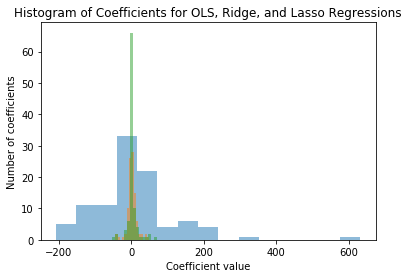

In [28]:
#plt.bar(ridge_coef_50,5, width=0.8)
ols_hist = plt.hist(ols_coef, alpha =.5, bins = 15)
ridge_hist = plt.hist(ridge_coef_50, alpha=.5, bins = 15)
lasso_hist = plt.hist(lasso_coef_1, alpha=.5, bins = 15)
plt.title('Histogram of Coefficients for OLS, Ridge, and Lasso Regressions')
plt.xlabel('Coefficient value')
plt.ylabel('Number of coefficients')
# plt.figure(figsize=(100, 100))

**3.3** The plots above show the overall distribution of coefficient values in each model, but do not show how each model treats individual coefficients. Build a plot which cleanly presents, for each feature in the data, 1) The coefficient assigned by OLS, 2) the coefficient assigned by ridge, and 3) the coefficient assigned by lasso.

**Hint: Bar plots are a possible choice, but you are not required to use them**

**Hint: use `xticks` to label coefficients with their feature names**

In [29]:
ols_coef_df = pd.DataFrame(ols_coef, index = x_train.columns.values)
ridge_coef_df = pd.DataFrame(ridge_coef_50, index = x_train.columns.values)
lasso_coef_df = pd.DataFrame(lasso_coef_1, index = x_train.columns.values)
coef_df = pd.concat([ols_coef_df, ridge_coef_df, lasso_coef_df],axis = 1,join_axes=[ols_coef_df.index] )
coef_df.columns = ['OLS', 'Ridge','Lasso']
display(coef_df.loc['temp'], coef_df.loc['atemp'])

OLS      162.171690
Ridge     38.049980
Lasso     71.683984
Name: temp, dtype: float64

OLS     -95.906513
Ridge    27.676077
Lasso     7.044429
Name: atemp, dtype: float64

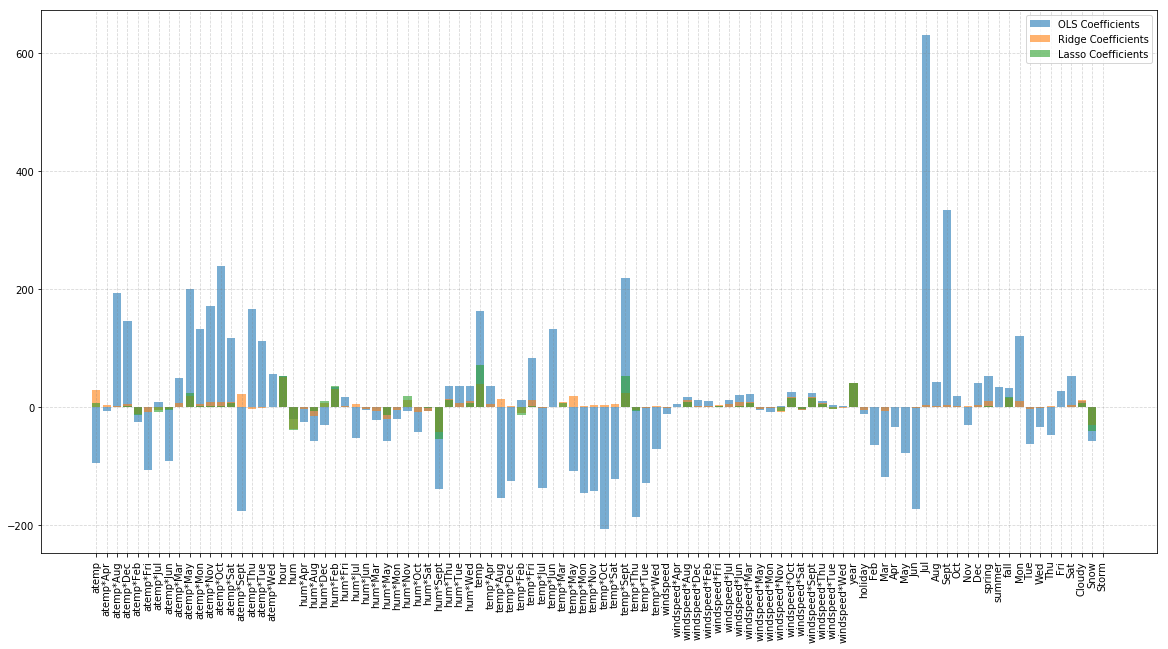

In [30]:
# Basic Bar Plot
x_vals = x_train.columns.values
plt.figure(figsize=(20,10))
plt.grid(b=True, which='major', color='tab:gray', alpha = .3, linestyle='--')
plt.xticks(rotation=90)
ols_bar = plt.bar(x_vals, ols_coef, alpha = .6)
ridge_bar = plt.bar(x_vals, ridge_coef_50, alpha =.6)
lasso_bar =plt.bar(x_vals, lasso_coef_1, alpha = .6)
plt.legend([ols_bar, ridge_bar, lasso_bar], ['OLS Coefficients','Ridge Coefficients', 'Lasso Coefficients'])

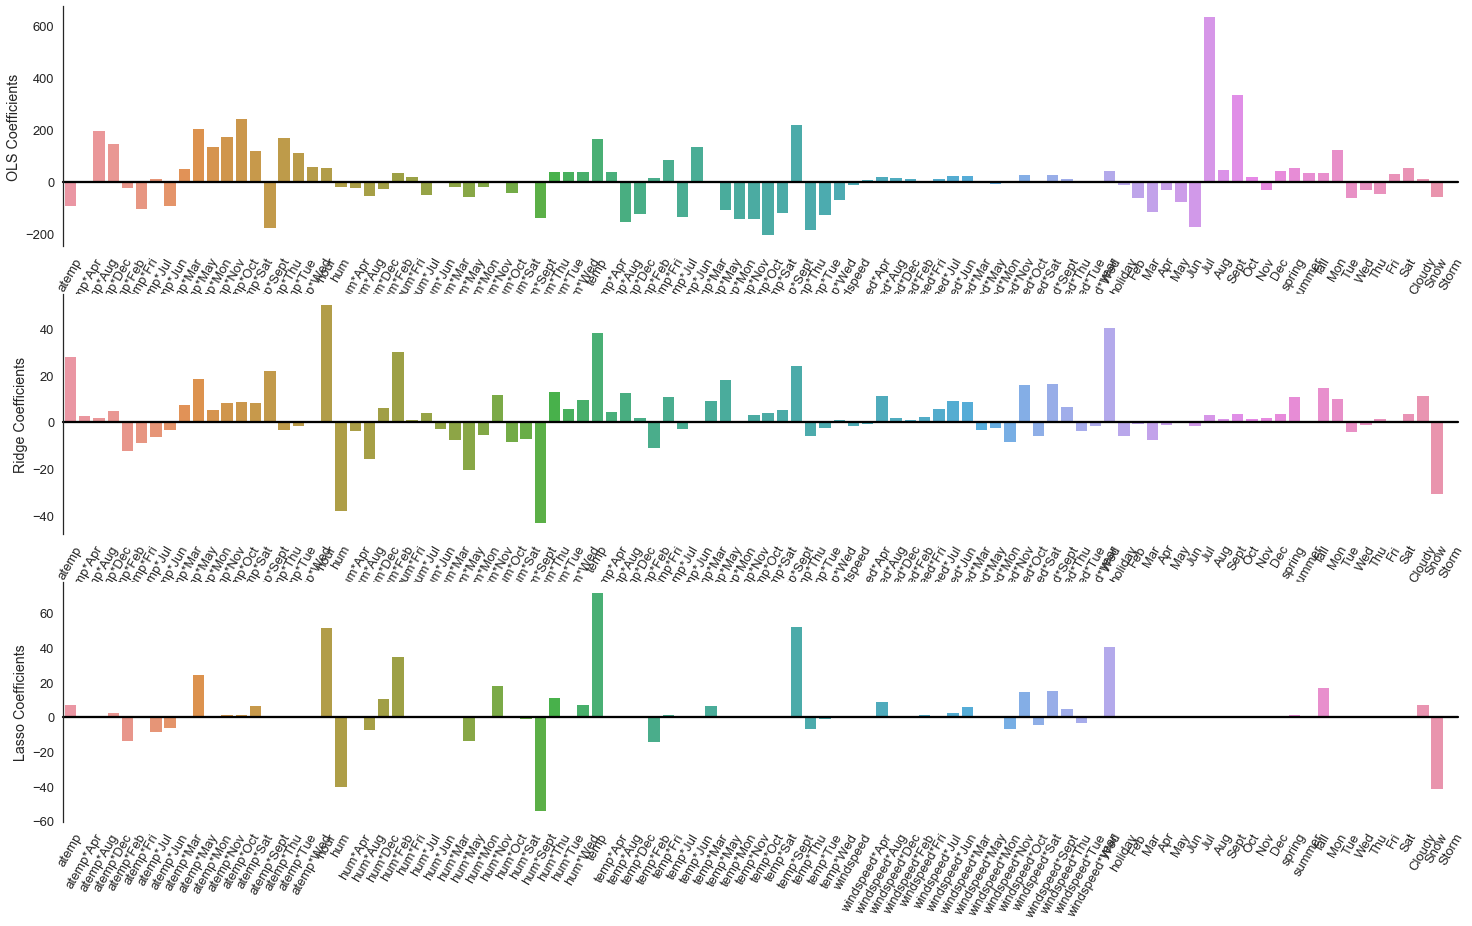

In [31]:
import seaborn as sns

sns.set(style="white", context="talk")
rs = np.random.RandomState(8)

# Set up the matplotlib figure
f, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(25, 15))

# OLS
x = coef_df.index
y1 = coef_df['OLS']
sns.barplot(x=x, y=y1, ax=ax1)
ax1.axhline(0, color="k", clip_on=False)
ax1.set_ylabel("OLS Coefficients")
ax1.set_xticklabels(coef_df.index, rotation=60)

# Ridge
y2 = coef_df['Ridge']
sns.barplot(x=x, y=y2, ax=ax2)
ax2.axhline(0, color="k", clip_on=False)
ax2.set_ylabel("Ridge Coefficients")
ax2.set_xticklabels(coef_df.index, rotation=60)

# Lasso
y3 = coef_df['Lasso']
sns.barplot(x=x, y=y3, ax=ax3)
ax3.axhline(0, color="k", clip_on=False)
ax3.set_ylabel("Lasso Coefficients")
ax3.set_xticklabels(coef_df.index,rotation=60)

# Finalize the plot
sns.despine(bottom=True)
#plt.setp(f.axes, yticks=[])
#plt.tight_layout(h_pad=2)

**3.4** What trends do you see in the plot above? How do the three approaches handle the correlated pair `temp` and `atemp`?

**Answer:** We see much more extreme coefficients for the OLS regression, whereas the Ridge and Lasso have much smaller coefficients. This tells us that OLS is more sensitive to a change in any feature. A more sensitive model can be more prone to overfitting, and it would be important to complete cross-validation on this model as a next step. The Lasso regression incurred the greatest penalization, and left us with about 8 dominant coefficients and about 26 other significant coefficients. The Ridge regression supplied a greater number of significant coefficients than Lasso, but at less extreme values than OLS.  

In terms of `temp` and `atemp`, each model handled the pair differently:  
- OLS chose two large values with inverse signs (162 and -95, respectively). Generally speaking, the `atemp` coefficient will negate the `temp` coefficient so their combined effective is net positive.  
- Ridge and Lasso both returned positive coefficients for `temp` and `atemp`. Both gave higher weights to `temp`, which is consistent with the OLS coefficient selection.


<div class='exercise'> <b> Question 4 [20 pts]: Reflection </b></div>
These problems are open-ended, and you are not expected to write more than 2-3 sentences. We are interested in seeing that you have thought about these issues; you will be graded on how well you justify your conclusions here, not on what you conclude.

**4.1** Reflect back on the `get_design_mats` function you built. Writing this function useful in your analysis? What issues might you have encountered if you copy/pasted the model-building code instead of tying it together in a function? Does a `get_design_mat` function seem wise in general, or are there better options?

**Answer:** I found `get_design_mats` to be incredibly useful in preparing my data. Since we were iterating over loops in Problems 2.1 and 2.3, using `get_design_mats` provided a simple, clean function that allowed us to split and pre-process our data. It would have been much more difficult and messy to split and pre-process the data manually, leaving a significant amount of room for user error.  

There are Python packages that have the ability to standardize data, so it may have been useful to use one of those. However, I am not away of packages with the ability to create polynomial features and interaction terms.

**4.2** What are the costs and benefits of applying ridge/lasso regularization to an overfit OLS model, versus setting a specific degree of polynomial or forward selecting features for the model?

**Answer:** Ridge and Lasso are beneficial because the minimize the impact of irrelevant features on our trained model. Ridge simply minimizes, but Lasso can force them to zero. This can help highlight the most relevant features, and make the model more interpretable. The overfit OLS is very, very difficult to interpret. However, when you use Ridge and Lasso, they can produce models that don't make sense/lack interpretability. Additionally, by ignoring or minimizing some non-significant variables, they take away our ability to gain interesting insights.

From a purely computation standpoint, the forward selection procedure was cumbersome to code, and took longer to iterate than applying the ridge/lasso. 

** 4.3** This pset posed a purely predictive goal: forecast ridership as accurately as possible. How important is interpretability in this context? Considering, e.g., your lasso and ridge models from Question 3, how would you react if the models predicted well, but the coefficient values didn't make sense once interpreted?

**Answer:** In the pset and the associated analysis, we are considering 113 possible features when creating our model. Interpertability becomes exponentially more difficult as we increase the number of features; that is, for a simple model with 2-3 features, we can easily read the coefficients and determine how features drive the outcome. For a model with 113 features, it hard to draw simple conclusions. We don't have a lot of insight into the causal associations, correlations, etc with all 113 features. Our model is so large it starts to becomes a 'black box' in a sense that data comes in and data comes out but we can not really interpret the model with ease.

There's a tradeoff in the world of big data -- interpretability vs. accuracy. If we want our model to be more interpretable, we need to simplify it and use a small number (probably in the range of 2-8) features. If we want our model to be accurate, we should continue using all 113 features. The coefficient values may not always make intuitive sense if we use all 113 features, but it can reveal new hidden patterns and dependencies in our data.


**4.4** Reflect back on our original goal of helping BikeShare predict what demand will be like in the week ahead, and thus how many bikes they can bring in for maintenance. In your view, did we accomplish this goal? If yes, which model would you put into production and why? If not, which model came closest, what other analyses might you conduct, and how likely do you think they are to work

**Answer:** I believe wehave accomplished this goal. In this particular instance, BikeShare values a very accurate model because they want to be able to enter the features for the upcoming days and forecast the capacity for maintenance. In this case, I specifically like the Ridge model. We can clearly see that both the Ridge and Lasso give high importance to the same features. However, many features in Lasso have coefficients of 0, including almost all the months of the year and almost all the days of the week. While they are accounted for in interaction variables, I believe some of these features do, in fact, play a factor in BikeShare usage anf they should still be considered. The Ridge allows us to consider all features, with reasonable coefficients.